In [1]:
#!/usr/bin/env python3

# Import relevant libraries to make HTTP requests and parse JSON response
import requests
import json
import csv
import io

from collections import defaultdict
from time import time
from sklearn import metrics


In [2]:
# Set disease_id variable for triple-negative breast cancer
disease_id = "EFO_0005537"

# Build query string to get target information as well as count
query_string = """
query KnownDrugs {
  disease(efoId: "EFO_0005537") {
    id
    name
		associatedTargets (page: {size: 3, index: 0}) {
      rows{
        score
        target{
          id
          approvedName
          approvedSymbol
          knownDrugs{
            rows{
              drug{
                name
                id
              }
            }
          }
        }
      }
    }
}
}
"""

In [3]:
# Set variables object of arguments to be passed to endpoint
variables = {"efoId": disease_id}

# Set base URL of GraphQL API endpoint
base_url = "https://api.platform.opentargets.org/api/v4/graphql"

# Perform POST request and check status code of response
r = requests.post(base_url, json={"query": query_string, "variables": variables})
print(r.status_code)

#Transform API response from JSON into Python dictionary and print in console
api_response = json.loads(r.text)
print('done')
#print(api_response)

200
done


In [4]:
a=0
#create list of target IDs by calling them from dictionary
target_ids = api_response['data']['disease']['associatedTargets']['rows']
#print(target_ids)
target_id_list = []
#pull IDs from dictionary and add to new list
while a < len(target_ids):
    target_id_list.append(target_ids[a]['target'].get('id'))
    a+=1
print(target_id_list)


['ENSG00000184292', 'ENSG00000198900', 'ENSG00000120217']


In [ ]:
# Create new dictionary assigning assays to to each target, and assigning compounds to each assay using PUG REST
# Able to write dictionary at a speed of 4 targets/second

a=0
target_id_assay_dict = {}
counter = 0
for target_id in target_id_list:
    counter = counter + 1
    if counter > 3 :
      break
# get raw AIDs (Assay IDs) for each Ensemble ID in JSON format using PUG REST
    r = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/gene/synonym/Ensemble:' + target_id + '/aids/json')
# convert JSON to Python Dictionary
    raw_aids = r.json()
    #print(type(raw_aids))
# isolate raw_aids into a list containing just the AIDs from the dictionary
    try:
        aids = raw_aids['InformationList']['Information'][0]['AID']
    except:
        pass
# assign each Ensamble Target ID to dictionary entry with associated Assay IDs
    #target_id_assay_dict[id] =  aids

    #create sub-dictionary for compounds within each assay
    target_id_assay_dict[target_id] =  {}
    for aid in aids:
        aid = str(aid)
        print(aid)
        #get raw CIDS (Compound IDs) for each Assay in JSON format using PUG REST
        r = requests.get('https://pubchem.ncbi.nlm.nih.gov/assay/pcget.cgi?query=download&record_type=datatable&actvty=active&response_type=display&aid=' + aid)

        loose_data = r.text

        listed_data = loose_data.split(',')
        try:
            cid_index = listed_data.index("PUBCHEM_CID")
        except:
            continue
        #print(cid_index)
        #print(type(cid_index))

        activity_index = listed_data.index("PUBCHEM_ACTIVITY_SCORE")
        #print(activity_index)
        #print(type(activity_index))


        fhand = io.StringIO(loose_data)

        cids_with_activities = []

        for line in fhand:
            line = line.split(',')

            while ('' in line):
                line.remove('')
            try:
                int(line[0])
                int(line[cid_index])
                float(line[activity_index])
            except:
                line = ""
                continue
            cid_with_activity = (line[cid_index], line[activity_index])
            cids_with_activities.append(cid_with_activity)
        #isolate raw_cids into a list containing just the CIDs from the dictionary
        if len(cids_with_activities) > 0:
            #assign CIDs to associated AID dictionary entry
            target_id_assay_dict[target_id][aid] = cids_with_activities
            print("Compounds found! Adding compounds to dictionary and passing to next assay.")
        else:
            print("No compounds found for assay. Passing to next assay.")
            continue

    a+=1
    display(a)
print(target_id_assay_dict)

In [7]:
#Precautions to ensure the code works right and the the Assay ID numbrs line up right
print(aids)
print(len(aids))


[1904, 56396, 56397, 56398, 56399, 56400, 56401, 56402, 56403, 56404, 56405, 56406, 56407, 56408, 56409, 56410, 56411, 56412, 56413, 56414, 56415, 56416, 56417, 56418, 56419, 56420, 56541, 56542, 56543, 56544, 56545, 56546, 56547, 56548, 56549, 56550, 56551, 56552, 56553, 56554, 56555, 56556, 56557, 56558, 56559, 56560, 56561, 56562, 56563, 56564, 56565, 56566, 56567, 56568, 56569, 56570, 56571, 56572, 56573, 56574, 56575, 56576, 56577, 56699, 56700, 56701, 56702, 56703, 56704, 56705, 56706, 56707, 56708, 56709, 56710, 56711, 56712, 56713, 56714, 56715, 56716, 56717, 56718, 56719, 56720, 56721, 56722, 56723, 56724, 56725, 56726, 56727, 56728, 56729, 56730, 56731, 56732, 56733, 56864, 56865, 56866, 56867, 56868, 56869, 56870, 56871, 56872, 56873, 56874, 56875, 56876, 56877, 56878, 56879, 56880, 56881, 56882, 56883, 56884, 56885, 56886, 56887, 56888, 56889, 56890, 56891, 56892, 56893, 56894, 56895, 56896, 56897, 56898, 56899, 56900, 56901, 57032, 57033, 57034, 57035, 57036, 57037, 57038,

In [ ]:
#Thomas Passaro working on my own request using the URL From John Marinelli.

from os import X_OK

#List made to hold all the Assay Descriptions
Assay_Descriptions_List = []

#Counter used to break out for test purposes
Count = 0

#A for loop used to cycle through the Assay ID numbers.
for i in aids:

  #this prints the Assay ID number before the name of the Assay. I find this gives more information for the user.
  print(str(i))

  #count to stop after a certain number of Assays (For test purposes)
  Count = Count +1
  if Count > 40:
    break
  #this is the calling of the request from the URL and it includes the cycling of Assay ID numbers.
  description_requests = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'+ str(i) +'/description/JSON')
  URL_Dict = description_requests.json()

  #Assay_Names is URL_Dict after it went through a few indexs
  Assay_Names = URL_Dict['PC_AssayContainer'][0]['assay']['descr']['name']
  print(Assay_Names)

  #Assay_Descriptions is the URL_Dict after it went through a few indexs to get the decriptions of each Assay
  Assay_Descriptions = URL_Dict['PC_AssayContainer'][0]['assay']['descr']['description']

  #Makes the descriptions all one string instead of multiple
  Assay_Descriptions_Joined = ' '.join(Assay_Descriptions)
  print(Assay_Descriptions_Joined)

  #adds the Descriptions of the Assays to the Assay Description List
  Assay_Descriptions_List.append(Assay_Descriptions_Joined)


In [ ]:
print(Assay_Descriptions_List)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
Assay_Train_Counts.shape
print(Assay_Train_Counts)
print(Assay_Train_Counts.toarray())

In [36]:
print(Assay_Count_Vect.get_feature_names_out())
print(Assay_Train_Counts.shape)

['000' '10' '100' '12' '135' '160' '200' '50' '90' 'abstract' 'activities'
 'activity' 'additional' 'against' 'also' 'amplitude' 'an' 'and' 'are'
 'as' 'at' 'basic' 'bind' 'binding' 'biological' 'bisindolylmaleimides'
 'cells' 'cellular' 'characterization' 'clock' 'compounds' 'concentration'
 'conducted' 'contain' 'corresponding' 'cytotoxicity' 'dependent'
 'described' 'description' 'did' 'dimethylamino' 'dna' 'due' 'effects'
 'electrostatically' 'ester' 'evaluation' 'exhibited' 'function' 'genes'
 'genome' 'greater' 'groove' 'however' 'human' 'hundreds' 'identify' 'in'
 'inc' 'increase' 'increased' 'inhibit' 'inhibition' 'inhibitory' 'is'
 'knockdown' 'length' 'lexitropsins' 'linked' 'manner' 'methyl' 'microm'
 'minor' 'model' 'modified' 'modifiers' 'moiety' 'nearly' 'neutral' 'nor'
 'not' 'number' 'observed' 'of' 'oligopeptide' 'on' 'or' 'order' 'period'
 'potently' 'presumably' 'propyl' 'pyrrole' 'qiagen' 'reduced' 'relative'
 'respectively' 'rhythm' 'screen' 'series' 'sirnas' 'subs

In [29]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram

n_clusters = 10  # number of regions
X = Assay_Train_Counts.toarray()

ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances = True
)
ward.fit(X)



AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        n_clusters=10)

In [34]:
!pip install seaborn

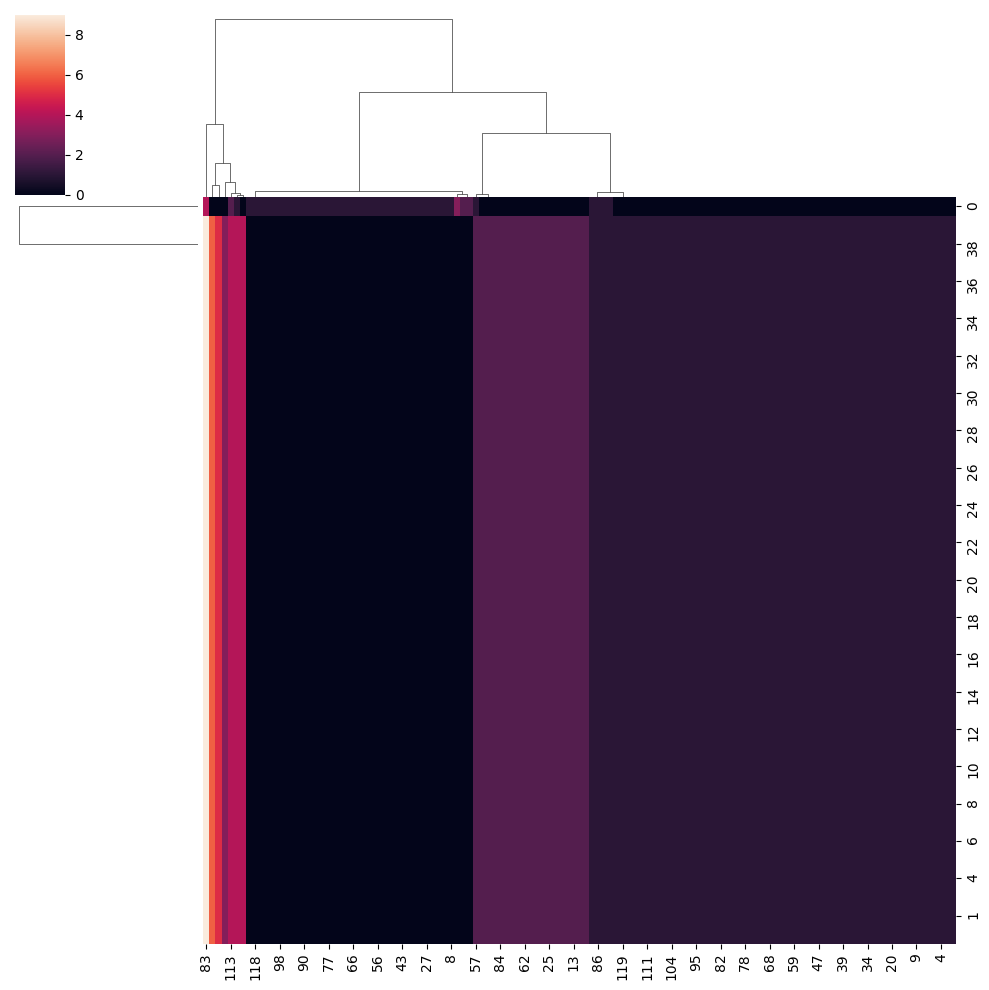

In [39]:
import seaborn

seaborn.clustermap(X,method='ward')

